# Calculate events in Circular Restricted Three Body Problem

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from fastrk import BT8713M, RKCodeGen, EventsCodeGen
from model_crtbp import crtbp
from timeit import timeit
from numba import njit
import orbipy as op

In [2]:
# Orbipy uses scipy.integrate.ode
model = op.crtbp3_model()

# Events

ev_y = op.eventY(0., terminal=False)
ev_z = op.eventZ(0., terminal=False)
ev_vx = op.eventVX(0., terminal=False)
ev_vy = op.eventVY(0., terminal=False)
ev_vz = op.eventVZ(0., terminal=False)

events = [ev_y, ev_z, ev_vx, ev_vy, ev_vz]

In [3]:
# generate code and import rk_prop function
# new module rk_bt8713m.py will be created (at first call) or loaded
# CRTBP is autonomous system i.e. equations doesn't have explicit time dependency

rk_module = RKCodeGen(BT8713M, autonomous=True).save_and_import()
rk_prop = rk_module.rk_prop
rk_prop_ev = rk_module.rk_prop_ev

# after first run code above can be replaced by
# from rk_8713M import rk_prop, rk_prop_ev


In [4]:
# generate code and import call_event function;
# new module __evcache__/ev_<hash>.py will be created (at first call) or loaded;
# call_event(t, s, values, idx) function calls specific event function by its index in events list

call_event = EventsCodeGen(events).save_and_import()

In [5]:
# Let's define Cauchy's problem:
# initial time and state for halo orbit

t0 = 0.
t1 = 3*np.pi
s0 = np.zeros(6)
s0[[0, 2, 4]] = 9.949942666080747733e-01, 4.732924802139452415e-03, -1.973768492871211949e-02
mc = np.array([3.001348389698916e-06])

In [6]:
# integration parameters, same as in Orbipy
params = {'max_step': np.inf,
          'rtol': 1e-12,
          'atol': 1e-12,
          }

In [7]:
# event detector object
dtr = op.event_detector(model, events)

df, evdf = dtr.prop(s0, t0, t1)

In [8]:
values = np.array([e.value for e in events])
terminals = np.array([e.terminal for e in events])
directions = np.array([e.direction for e in events])
counts = np.array([e.count for e in events])
accurates = np.array([e.accurate for e in events])

trj, evarr = rk_prop_ev(crtbp, s0, 0, t1, *params.values(),
                        values, terminals, directions, counts, accurates,
                        call_event, 1e-12, 1e-12, 100, mc)

In [9]:
evdf1 = pd.DataFrame(evarr, columns=['e', 'cnt', 't', 'x', 'y', 'z', 'vx', 'vy', 'vz'])

In [10]:
# check event times
evdf.t - evdf1.t

0    -4.922285e-12
1     4.164447e-12
2     7.951861e-12
3     3.029155e-11
4     4.951595e-13
5     5.851453e-11
6     1.755840e-11
7     1.680007e-10
8    -6.343224e-10
9     1.618141e-10
10    4.295067e-10
11    1.630771e-10
12   -7.911112e-10
13    6.959928e-09
14    2.087988e-09
15    1.687998e-08
16    8.396579e-09
17    5.646641e-08
18   -2.277712e-07
19    5.820032e-08
20    1.568987e-07
21    5.598841e-08
22   -2.966316e-07
23    2.560417e-06
24    7.688840e-07
25    6.216301e-06
26    3.096731e-06
27    2.080954e-05
28   -8.392425e-05
29    2.144755e-05
Name: t, dtype: float64

In [11]:
evdf[evdf.e == 0].y - evdf1[evdf1.e == 0].y

2     2.089539e-17
7    -1.923244e-18
12   -3.282024e-16
17   -1.551711e-13
22    1.787718e-16
27   -2.841581e-13
Name: y, dtype: float64

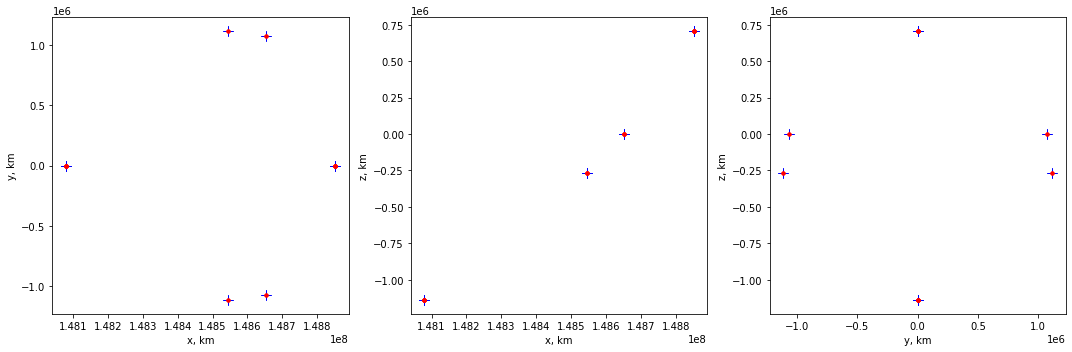

In [12]:
pltr = op.plotter.from_model(model)

ax = pltr.plot_proj(evdf, color='b', ls='', marker='+', ms=10)
pltr.plot_proj(evdf1, color='r', ls='', marker='.', ax=ax);

In [13]:
loops = 1000
str0 = "dtr.prop(s0, t0, t1)"
str1 = """rk_prop_ev(crtbp, s0, 0, t1, *params.values(),
                     values, terminals, directions, counts, accurates,
                     call_event, 1e-12, 1e-12, 100, mc)"""

r0 = timeit(str0, number=loops, globals=globals())
r1 = timeit(str1, number=loops, globals=globals())

print(f"orbipy DOP853 time {r0:.2f}")
print(f"fastrk DOP8713M time {r1:.2f}")
print(f"speedup x {r0/r1:.2f}")


orbipy DOP853 time 11.94
fastrk DOP8713M time 2.15
speedup x 5.56


In [14]:
@njit
def event_0(t, s, *args):
    return s[1]

@njit
def event_1(t, s, *args):
    return s[2]

@njit
def event_2(t, s, *args):
    return s[3]

@njit
def event_3(t, s, *args):
    return s[4]

@njit
def event_4(t, s, *args):
    return s[5]

# use solve_ivp to calculate events
sol = solve_ivp(crtbp, (t0, t1), s0,
                method='DOP853', **params,
                args=(mc,),
                events=[event_0, event_1, event_2, event_3, event_4])

In [15]:
loops = 100
str0 = """solve_ivp(crtbp, (t0, t1), s0,
                method='DOP853', **params,
                args=(mc,),
                events=[event_0, event_1, event_2, event_3, event_4])"""
str1 = """rk_prop_ev(crtbp, s0, 0, t1, *params.values(),
                     values, terminals, directions, counts, accurates,
                     call_event, 1e-12, 1e-12, 100, mc)"""

r0 = timeit(str0, number=loops, globals=globals())
r1 = timeit(str1, number=loops, globals=globals())

print(f"solve_ivp DOP853 time {r0:.2f}")
print(f"fastrk DOP8713M time {r1:.2f}")
print(f"speedup x {r0/r1:.2f}")

solve_ivp DOP853 time 3.33
fastrk DOP8713M time 0.23
speedup x 14.64


In [16]:
dfs = []
for i, evarr in enumerate(sol.y_events):
    df = pd.DataFrame(evarr, columns=['x','y','z','vx','vy','vz'])
    df['e'] = i
    df['t'] = sol.t_events[i]
    dfs.append(df)
    
evdf2 = pd.concat(dfs, axis=0)

In [17]:
# solve ivp calculated additional events at initial time
# let's drop it and sort by time
evdf3 = evdf2[evdf2.t > 1e-19].sort_values(by='t').reset_index(drop=True)

# check event times
evdf1.t - evdf3.t

0    -8.041345e-13
1    -4.182210e-12
2     5.034195e-12
3     5.329515e-12
4    -4.885536e-11
5    -6.132028e-11
6    -7.583267e-12
7     1.250800e-09
8    -4.293552e-10
9    -1.917329e-10
10   -4.590919e-10
11   -1.805041e-10
12    8.527259e-10
13   -7.454881e-10
14   -9.032499e-09
15   -1.817942e-08
16   -9.089208e-09
17    3.349717e-07
18   -1.498620e-07
19   -6.288217e-08
20   -1.695434e-07
21   -6.051879e-08
22    3.205262e-07
23   -2.707491e-07
24   -3.326816e-06
25   -6.717160e-06
26   -3.346280e-06
27    1.234403e-04
28   -5.524237e-05
29   -2.317578e-05
Name: t, dtype: float64

In [18]:
evdf[evdf.e == 0].y.to_numpy() - evdf3[evdf3.e == 0].y.to_numpy()

array([ 4.40457133e-19, -4.92973175e-19,  1.08420217e-17, -1.55174844e-13,
        1.08420217e-17, -2.84147326e-13])

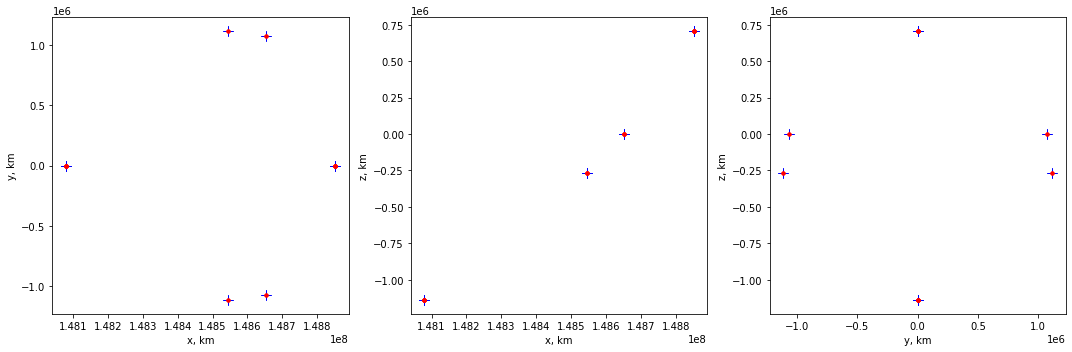

In [19]:
ax = pltr.plot_proj(evdf, color='b', ls='', marker='+', ms=10)
pltr.plot_proj(evdf3, color='r', ls='', marker='.', ax=ax);